In [1]:
import json

import numpy as np
import pandas as pd
from scapy.all import rdpcap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from IAT_dataparser import IATDataParser

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

In [2]:
data_path = "../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619005750_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"
# data_path = '../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619782605_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json'

# Instantiate DataParser class
data_parser = IATDataParser(data_path)

# Reading the biflow data
biflow_data = data_parser.biflow_data

biflows = list(biflow_data.keys())

print("biflows: ", biflows)
print('number of biflows: ', len(biflows))

biflows:  ['192.168.20.111,68,192.168.20.254,67,17', '192.168.20.111,51560,8.8.4.4,853,6', '192.168.20.111,46279,8.8.8.8,853,6', '192.168.20.111,55009,142.250.180.68,443,6', '192.168.20.111,55586,142.250.184.35,80,6', '192.168.20.111,51564,8.8.4.4,853,6', '192.168.20.111,40978,108.177.127.188,5228,6', '192.168.20.111,38155,142.250.184.36,443,17', '192.168.20.111,38544,142.250.184.36,443,6', '192.168.20.111,39646,172.217.21.67,443,6', '192.168.20.111,33755,142.250.184.42,443,6', '192.168.20.111,32786,216.58.205.74,443,6', '192.168.20.111,41662,216.58.206.42,443,6', '192.168.20.111,41663,216.58.206.42,443,6', '192.168.20.111,41513,216.58.198.46,443,6', '192.168.20.111,41515,216.58.198.46,443,6', '192.168.20.111,37742,142.250.180.74,443,17', '192.168.20.111,57411,142.250.180.74,443,17', '192.168.20.111,36736,142.250.180.74,443,6', '192.168.20.111,36737,142.250.180.74,443,6', '192.168.20.111,51073,216.58.198.42,443,17', '192.168.20.111,58540,216.58.198.42,443,6', '192.168.20.111,50145,216.

In [3]:
# all_IAT = data_parser.aggregate_IAT()

# # Saturate to the 99th percentile
# all_IAT = data_parser.saturate_99(all_IAT)
# # Apply minmax scaling to the data
# all_IAT = data_parser.minmax_scaler(all_IAT)

test_IAT = data_parser.generate_debug_set()
test_IAT = data_parser.saturate_99(test_IAT)
test_IAT = data_parser.minmax_scaler(test_IAT)

len(test_IAT)

# data_parser.plotIAT_minmax(all_IAT)

1314

In [6]:
# DEFINE WINDOWS AND BATCH SIZE HERE
memory_window = 63
prediction_window = 1 
batch_size = 32

# memory_window_set, gd_truth_set = data_parser.create_sequences(
#     all_IAT['Interarrival_scaled'], memory_window, prediction_window)  # Splitting data into memory_window and prediction_window (ground truth)

memory_window_set, gd_truth_set = data_parser.create_sequences(
    test_IAT['Interarrival_scaled'], memory_window, prediction_window)  # Splitting data into memory_window and prediction_window (ground truth)

# display(memory_window_set)
print(f"Input shape: {memory_window_set.shape}, Output shape: {gd_truth_set.shape}")

train_loader, test_loader = data_parser.data_set_generator(memory_window_set, gd_truth_set, batch_size)

print(train_loader)
print(test_loader)

for idx, (data, target) in enumerate(train_loader):
    print(data.shape)

Input shape: (1251, 63), Output shape: (1251, 1)
X_train shape:  torch.Size([251, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([8, 63])


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layer 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32,
                      kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3)
        )

        # Convolutional layer 2
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64,
                      kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3)
        )

        self.out = nn.Linear(64 * 7, prediction_window)

    def forward(self, x):
        # print("Size of x: ", x.size())
        x = x.unsqueeze(0).permute(1, 0, 2)
        # print("Size of x: ", x.size())
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [8]:
cnn = CNN()
print(cnn)
loss_func = nn.MSELoss()
print(loss_func)
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
print(optimizer)

CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=448, out_features=1, bias=True)
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [9]:
num_epochs = 20
# num_epochs = 1

# Function to calculate RMSE
def calculate_rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))


# Lists to store loss and RMSE
train_rmse_list = []
val_rmse_list = []

# Training loop
for epoch in range(num_epochs):
    cnn.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = cnn(X_batch)[0]
        # y_batch = y_batch.squeeze(-1)
        # print("outputs size: ", outputs.size())
        # print("y_batch size: ", y_batch.size())
        loss = loss_func(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Calculate average training loss
    train_loss = np.mean(train_losses)

    # Calculate training RMSE
    train_rmse = calculate_rmse(
        outputs.detach().cpu().numpy(), y_batch.detach().cpu().numpy())
    train_rmse_list.append(train_rmse)

    # Print loss every 10 epochs
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([8, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32, 63])
torch.Size([32

Test RMSE: 0.1392


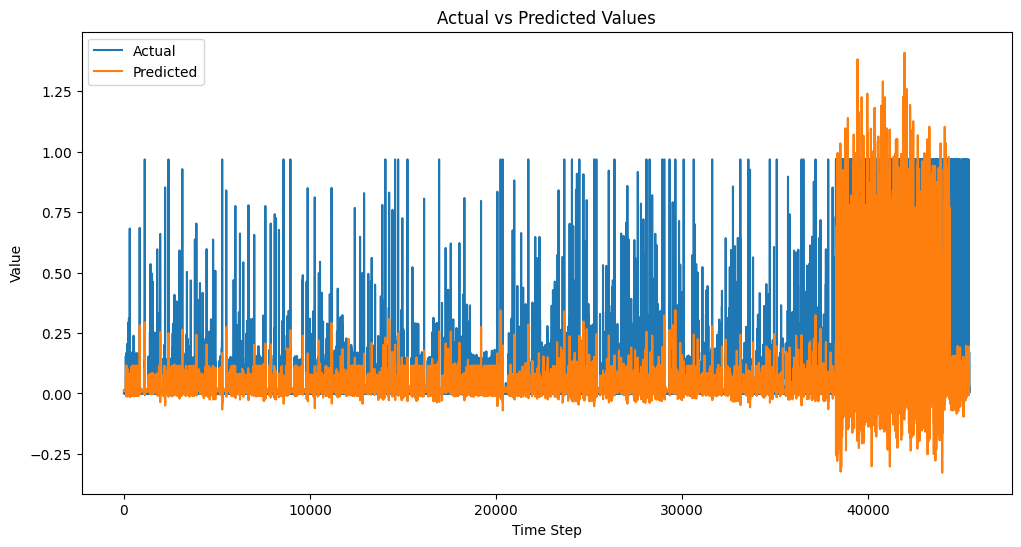

In [ ]:
scaler = data_parser.get_minmax_scaler()

# Evaluate the model
cnn.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # x = x.unsqueeze(0)
        # print("size of X_batch: ", X_batch.size())
        # X_batch = X_batch.transpose(1, 2).contiguous()
        outputs = cnn(X_batch)[0]
        predictions.append(outputs.numpy())
        actuals.append(y_batch.numpy())

predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# print("Predictions: ", predictions)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
# print("actuals size before squeezing: ", actuals.shape)
# actuals = actuals.squeeze(-1)
# print("actuals size: ", actuals.shape)
actuals = scaler.inverse_transform(actuals)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f'Test RMSE: {rmse:.4f}')

# Plot the actual vs predicted values for the first test sample
plt.figure(figsize=(12, 6))
# plt.plot(range(len(actuals[11000])), actuals[0], label='Actual')
# plt.plot(range(len(predictions[11000])), predictions[0], label='Predicted')

plt.plot(range(len(actuals)), actuals, label='Actual')
plt.plot(range(len(predictions)), predictions, label='Predicted')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()